# Tensorflow Eager Execution Basics

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.enable_eager_execution()
tfe=tf.contrib.eager

C:\Users\compu\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Add

print(tf.add(1,2))
print(tf.add([1,2,3,4,5],[6,7,8,9,10]))

tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor([ 7  9 11 13 15], shape=(5,), dtype=int32)


In [3]:
# operations
print("Square: ",tf.square(4))
print("Reduce sum: ",tf.reduce_sum([1,2,3,4,5]))

Square:  tf.Tensor(16, shape=(), dtype=int32)
Reduce sum:  tf.Tensor(15, shape=(), dtype=int32)


In [4]:
# Encode a string
print(tf.encode_base64("hello world"))

tf.Tensor(b'aGVsbG8gd29ybGQ', shape=(), dtype=string)


In [4]:
# Matmul
x=tf.matmul([[1]],[[2,3]])
print(x)
print(x.shape)
print(x.dtype)

tf.Tensor([[2 3]], shape=(1, 2), dtype=int32)
(1, 2)
<dtype: 'int32'>


### GPU accelaration

In [7]:
x=tf.random_uniform([3,3])

print("GPU avaliable?")
print(tf.test.is_gpu_available())

print("Is the Tensor on GPU:0")
print(x.device.endswith("GPU:0"))

GPU avaliable?
True
Is the Tensor on GPU:0
True


In [9]:
# show the location of the tensor
print("Device: ",x.device)

Device:  /job:localhost/replica:0/task:0/device:GPU:0


Explicit device placement

In [13]:
def time_matmul(x):
  %timeit tf.matmul(x,x)
  

  
# Force  execution on CPU
print("ON CPU:0")
with tf.device('CPU:0'):
    x=tf.random_uniform([1000,1000])
    assert x.device.endswith("CPU:0")
    time_matmul(x)
  
  
  
  
  

ON CPU:0
100 loops, best of 3: 26.7 ms per loop


In [14]:
# Force execution on GPU
print('ON GPU:0')
if tf.test.is_gpu_available():
  with tf.device("GPU:0"):
    x=tf.random_uniform([1000,1000])
    assert x.device.endswith('GPU:0')
    time_matmul(x)

ON GPU:0
1000 loops, best of 3: 1.11 ms per loop


## Datsets API
We don't need to use iterators objects for tf eager execution 

In [14]:
ds_tensors=tf.data.Dataset.from_tensor_slices([1,2,3,4,5,6])


import tempfile
# Create a CSV
_,filename=tempfile.mkstemp()

with open(filename,'w') as f:
     f.write("""Line 1
     Line 2
     Line 3""")
    
ds_file=tf.data.TextLineDataset(filename)
for i in ds_file:
    print(i)

tf.Tensor(b'Line 1', shape=(), dtype=string)
tf.Tensor(b'     Line 2', shape=(), dtype=string)
tf.Tensor(b'     Line 3', shape=(), dtype=string)


**Apply Transformations**

In [15]:
# Data tensor
ds_tensors=ds_tensors.map(tf.square).shuffle(2).batch(2)


#  File
ds_file=ds_file.batch(2)


**Iterate**

In [16]:
print('Elements os ds_Tensors: ')
for x in ds_tensors:
    print(x)
    
print("\n Elements in ds_file: ")
for x in ds_file:
    print(x)

Elements os ds_Tensors: 
tf.Tensor([4 9], shape=(2,), dtype=int32)
tf.Tensor([16 25], shape=(2,), dtype=int32)
tf.Tensor([ 1 36], shape=(2,), dtype=int32)

 Elements in ds_file: 
tf.Tensor([b'Line 1' b'     Line 2'], shape=(2,), dtype=string)
tf.Tensor([b'     Line 3'], shape=(1,), dtype=string)


# Automatic differentiation and gradient tape

In [ ]:
# SETUP
tfe=tf.contrib.eager

### Derivatives of a function
TensorFlow provides APIs for automatic differentiation - computing the derivative of a function. The way that more closely mimics the math is to encapsulate the computation in a Python function, say f, and use tfe.gradients_function to create a function that computes the derivatives of f with respect to its arguments

In [20]:
from math import pi
import numpy as np

# Create a function of the operations 
def f(x):
  return tf.square(tf.sin(x))

assert f(pi/2).numpy()==1.0

grad_f=tfe.gradients_function(f)
assert tf.abs(grad_f(pi/2)[0]).numpy() <1e-7

In [30]:
grad_f(np.pi/2)

[<tf.Tensor: id=577, shape=(), dtype=float32, numpy=-8.742278e-08>]

In [18]:
print("Value: ",grad_f(pi/2)[0].numpy())

Value:  -8.742278e-08


**Higher Order Gradients**

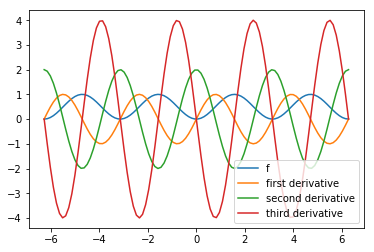

In [19]:
def grad(f):
  return lambda x:tfe.gradients_function(f)(x)[0]

x=tf.lin_space(-2*pi,2*pi,100)

import matplotlib.pyplot as plt 

plt.plot(x, f(x), label="f")
plt.plot(x, grad(f)(x), label="first derivative")
plt.plot(x, grad(grad(f))(x), label="second derivative")
plt.plot(x, grad(grad(grad(f)))(x), label="third derivative")
plt.legend()
plt.show()

### Gradient Tapes
Every differentiable TensorFlow operation has an associated gradient function. For example, the gradient function of tf.square(x) would be a function that returns 2.0 * x. To compute the gradient of a user-defined function (like f(x) in the example above), TensorFlow first "records" all the operations applied to compute the output of the function. We call this record a "tape". It then uses that tape and the gradients functions associated with each primitive operation to compute the gradients of the user-defined function using reverse mode differentiation.

In [31]:
def f(x,y):
  output=1
  for i in range(int(y)):
      output=tf.multiply(output,x)
  
  return output
  
  
def grad(x,y):
    return tfe.gradients_function(f)(x,y)[0]
  
print(f(3.0, 2))
print(grad(3.0,2))


tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(6.0, shape=(), dtype=float32)



At times it may be inconvenient to encapsulate computation of interest into a function. For example, if you want the gradient of the output with respect to intermediate values computed in the function. In such cases, the slightly more verbose but explicit `tf.GradientTape` context is useful. All computation inside the context of a tf.GradientTape is "recorded".

In [34]:
x=tf.ones((2,2))
x

<tf.Tensor: id=633, shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [1., 1.]], dtype=float32)>

In [38]:
x=tf.ones((2,2))

with tf.GradientTape(persistent=True) as t:
    t.watch(x)
    y=tf.reduce_sum(x)
    z=tf.multiply(y,y)

    
# Compute the derivative of Z with respect to y

dz_dy=t.gradient(z,y)
print("Derivative of Z with respect to y",dz_dy)
assert dz_dy.numpy()==8.0

# compute the derivative of Z with respect to x
dz_dx=t.gradient(z,x)
print("\n dz/dx: ",dz_dx)
assert dz_dx[0][0].numpy()==8.0


Derivative of Z with respect to y tf.Tensor(8.0, shape=(), dtype=float32)

 dz/dx:  tf.Tensor(
[[8. 8.]
 [8. 8.]], shape=(2, 2), dtype=float32)


In [40]:
dy_dx= t.gradient(y,x)
dy_dx[0].numpy()

array([1., 1.], dtype=float32)

**High Order Gradients**

In [41]:
x=tf.constant(1.0)


with tf.GradientTape() as t:
    with tf.GradientTape() as t2:
        # Record the second computation of X
        t2.watch(x)
        y=x**3
    # compute the gradient insede 't ' context 
    dy_dx=t2.gradient(y,x) # 3X^2
d2y_dx2=t.gradient(dy_dx,x) # 6 X

print("dy_dx: ", dy_dx)
print("d2y_dx2: ", d2y_dx2)

assert dy_dx.numpy()==3.0
assert d2y_dx2.numpy()==6.0


dy_dx:  tf.Tensor(3.0, shape=(), dtype=float32)
d2y_dx2:  tf.Tensor(6.0, shape=(), dtype=float32)


# Custom training: basics

## Variables
TensorFlow, however, has stateful operations built in, and these are often more pleasant to use than low-level Python representations of your state. To represent weights in a model, for example, it's often convenient and efficient to use TensorFlow variables.

A Variable is an object which stores a value and, when used in a TensorFlow computation, will implicitly read from this stored value. There are operations (`tf.assign_sub, tf.scatter_update`, etc) which manipulate the value stored in a TensorFlow variable.

In [28]:
x=tf.zeros([10,10])
x+=2

print(x)

tf.Tensor(
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]], shape=(10, 10), dtype=float32)


In [42]:
v= tfe.Variable(1.0)
assert v.numpy()==1.0
print("Original v: ",v.numpy())

v.assign(3.0)
print("Assign 3.0 to v: ",v.numpy())



Original v:  1.0
Assign 3.0 to v:  3.0


## Fitting a model

In [43]:
class Model(object):
    
    def __init__(self):
        
        self.W=tfe.Variable(5.0)
        self.b=tfe.Variable(0.0)
        
    def __call__(self,x):
        
        return self.W*x + self.b
      
model=Model()
print(model(3.0).numpy())
assert model(3.0).numpy()==15.0

15.0


Loss function

In [44]:
def loss(a,y):
    # Mean Square loss
    loss=tf.reduce_mean(tf.square(a-y))
    return loss

In [45]:
# Training Data
trueW=3.0
trueb=2.0

num_examples=1000
 #construyendo un dataset
inputs=tf.random_normal(shape=[num_examples])
noise=tf.random_normal(shape=[num_examples])
outputs=inputs*trueW+ trueb + noise

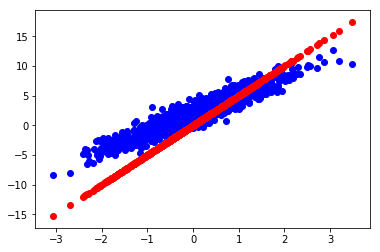

Current loss: 
8.957301


In [46]:


plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(inputs), c='r')

plt.show()

print('Current loss: '),
print(loss(model(inputs), outputs).numpy())

## Training loop

In [47]:
def train (model, inputs,outputs,learning_rate):
    """ Gradient Descent optimizer """
    with tf.GradientTape() as t:
        current_loss=loss(model(inputs),outputs)
    # compute the gradient outside the Gradient Tape    
    dW,db=t.gradient(current_loss, [model.W, model.b])
    # update rule 
    model.W.assign_sub(learning_rate*dW)
    model.b.assign_sub(learning_rate*db)

In [ ]:
def train(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs), outputs)
  dW, db = t.gradient(current_loss, [model.W, model.b])
  model.W.assign_sub(learning_rate * dW)
  model.b.assign_sub(learning_rate * db)

Epoch  0: W= 5.00 b=0.00, loss= 8.95730 
Epoch  1: W= 4.60 b=0.41, loss= 6.04000 
Epoch  2: W= 4.28 b=0.73, loss= 4.19568 
Epoch  3: W= 4.03 b=0.99, loss= 3.02969 
Epoch  4: W= 3.83 b=1.19, loss= 2.29254 
Epoch  5: W= 3.67 b=1.36, loss= 1.82651 
Epoch  6: W= 3.55 b=1.49, loss= 1.53187 
Epoch  7: W= 3.45 b=1.59, loss= 1.34560 
Epoch  8: W= 3.37 b=1.67, loss= 1.22783 
Epoch  9: W= 3.30 b=1.74, loss= 1.15337 


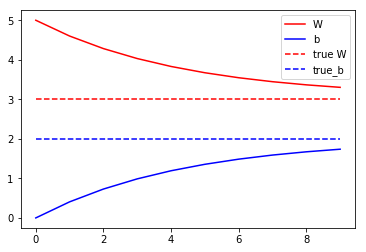

In [48]:
model = Model()

# history of Ws, bs
Ws,bs=[],[]

epochs=range(10)

for epoch in epochs:
    Ws.append(model.W.numpy())
    bs.append(model.b.numpy())
    current_loss=loss(model(inputs),outputs)
    
    train(model,inputs,outputs, learning_rate=0.1)
    print("Epoch %2d: W= %1.2f b=%1.2f, loss= %2.5f " %(epoch, Ws[-1], bs[-1], current_loss))
    
    
plt.plot(epochs, Ws, 'r',
         epochs, bs, 'b')
plt.plot([trueW] * len(epochs), 'r--',
         [trueb] * len(epochs), 'b--')
plt.legend(['W', 'b', 'true W', 'true_b'])
plt.show()

In [ ]:
model.W.assign_sub

# Custom Layers

In [ ]:
layer= tf.keras.layers.Dense(10, input_shape=(None,5)) # Linear 

In [35]:
layer(tf.zeros([10,5]))

<tf.Tensor: id=2559, shape=(10, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

In [36]:
layer.variables

[<tf.Variable 'dense_1/kernel:0' shape=(5, 10) dtype=float32, numpy=
 array([[-0.32335466, -0.04652661, -0.2294738 , -0.03265989,  0.10552812,
         -0.0588361 , -0.50648284,  0.40539736,  0.07949179, -0.6200976 ],
        [-0.01890504,  0.36584252,  0.59080595, -0.3556608 , -0.518607  ,
          0.61111695,  0.3106528 , -0.30859542, -0.18911493, -0.07746881],
        [ 0.30171293, -0.0522486 ,  0.524636  , -0.2638044 , -0.03667599,
         -0.06413513, -0.57257354, -0.29257798, -0.11131555, -0.5294789 ],
        [ 0.5993894 ,  0.48667735,  0.49677664,  0.0266307 ,  0.16942275,
         -0.5023005 , -0.56170523, -0.3044677 , -0.31300572, -0.06941682],
        [ 0.48530072, -0.49543494,  0.41260523,  0.3167804 ,  0.09553802,
         -0.4144342 , -0.46393055, -0.15369862,  0.3561839 ,  0.4906444 ]],
       dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>]

In [37]:
layer.kernel, layer.bias

(<tf.Variable 'dense_1/kernel:0' shape=(5, 10) dtype=float32, numpy=
 array([[-0.32335466, -0.04652661, -0.2294738 , -0.03265989,  0.10552812,
         -0.0588361 , -0.50648284,  0.40539736,  0.07949179, -0.6200976 ],
        [-0.01890504,  0.36584252,  0.59080595, -0.3556608 , -0.518607  ,
          0.61111695,  0.3106528 , -0.30859542, -0.18911493, -0.07746881],
        [ 0.30171293, -0.0522486 ,  0.524636  , -0.2638044 , -0.03667599,
         -0.06413513, -0.57257354, -0.29257798, -0.11131555, -0.5294789 ],
        [ 0.5993894 ,  0.48667735,  0.49677664,  0.0266307 ,  0.16942275,
         -0.5023005 , -0.56170523, -0.3044677 , -0.31300572, -0.06941682],
        [ 0.48530072, -0.49543494,  0.41260523,  0.3167804 ,  0.09553802,
         -0.4144342 , -0.46393055, -0.15369862,  0.3561839 ,  0.4906444 ]],
       dtype=float32)>,
 <tf.Variable 'dense_1/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>)

Note that you don't have to wait until build is called to create your variables, you can also create them in __init__. However, the advantage of creating them in build is that it enables late variable creation based on the shape of the inputs the layer will operate on. On the other hand, creating variables in __init__ would mean that shapes required to create the variables will need to be explicitly specified

In [49]:
class MyDenseLayer(tf.keras.layers.Layer):
    
    def __init__(self, num_outputs):
       
        super().__init__()
        self.num_outputs=num_outputs
        
    def build(self, input_shape):
        self.kernel= self.add_variable("kernel", shape=[input_shape[-1].value, self.num_outputs])
        
    # Foward propagation
    def call(self,input):
        return tf.matmul(input, self.kernel)
    
      

In [50]:
layer=MyDenseLayer(10)
print(layer(tf.zeros([10,5])))
print(layer.variables)

tf.Tensor(
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]], shape=(10, 10), dtype=float32)
[<tf.Variable 'my_dense_layer/kernel:0' shape=(5, 10) dtype=float32, numpy=
array([[-0.48788658, -0.3402177 , -0.01812816,  0.51327425,  0.25174022,
        -0.30073085,  0.49480218, -0.39557767, -0.41383868, -0.394495  ],
       [ 0.1826539 , -0.368508  ,  0.30589598, -0.4684924 ,  0.0646047 ,
        -0.11512315,  0.03346646,  0.20209515,  0.08467472, -0.10100174],
       [-0.2374469 ,  0.27657533,  0.42591769, -0.4487794 ,  0.47196847,
        -0.17450118,  0.2317617 ,  0.12837327, -0.25694156, -0.44353452],
       [ 0.04311877, -0.00187296,  0.54918057,  0.07244557, -0.5530077 ,
         0.0814777 , -0.11076671, -0

## Model composing layers

In [ ]:
class ResnetIdentityBlock(tf.keras.Model):
  
  def __init__(self, kernel_size, filters):
    super().__init__()
    # Filters
    filters1,filters2,filters3=filters
    
    # Define architecture
    self.conv2a=tf.keras.layers.Conv2D(filters1,(1,1))
    self.bn2a=tf.keras.layers.BatchNormalization()
    
    self.conv2b=tf.keras.layers.Conv2D(filters2,kernel_size,padding='same')
    self.bn2b=tf.keras.layers.BatchNormalization()
    
    self.conv2c=tf.keras.layers.Conv2D(filters3,(1,1))
    self.bn2c=tf.keras.layers.BatchNormalization()
    
  # Foward Propagation 
  def call(self,input_tensor,training=False):
    # block 1
    x= self.conv2a(input_tensor)
    x=self.bn2a(x,training=training)
    x=tf.nn.relu(x)
    
    # Block 2
    x=self.conv2b(x)
    x=self.bn2b(x,training=training)
    x=tf.nn.relu(x)
    
    # Block 3
    x=self.conv2c(x)
    x=self.bn2c(x,training=training)
    
    # Residual op
    x += input_tensor
    return tf.nn.relu(x)

In [70]:
block=ResnetIdentityBlock(1,[1,2,3])
print(block(tf.zeros([1,2,3,3])))
print([x.name for x in block.variables])

tf.Tensor(
[[[[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]

  [[0. 0. 0.]
   [0. 0. 0.]
   [0. 0. 0.]]]], shape=(1, 2, 3, 3), dtype=float32)
['resnet_identity_block/conv2d/kernel:0', 'resnet_identity_block/conv2d/bias:0', 'resnet_identity_block/batch_normalization/gamma:0', 'resnet_identity_block/batch_normalization/beta:0', 'resnet_identity_block/conv2d_1/kernel:0', 'resnet_identity_block/conv2d_1/bias:0', 'resnet_identity_block/batch_normalization_1/gamma:0', 'resnet_identity_block/batch_normalization_1/beta:0', 'resnet_identity_block/conv2d_2/kernel:0', 'resnet_identity_block/conv2d_2/bias:0', 'resnet_identity_block/batch_normalization_2/gamma:0', 'resnet_identity_block/batch_normalization_2/beta:0', 'resnet_identity_block/batch_normalization/moving_mean:0', 'resnet_identity_block/batch_normalization/moving_variance:0', 'resnet_identity_block/batch_normalization_1/moving_mean:0', 'resnet_identity_block/batch_normalization_1/moving_variance:0', 'resnet_identity_block/batch_normalization_2